# CNN

CNN의 구성 요소
- 합성곱 층: 입력 이미지의 모든 픽셀에 연결되는 것이 아니라 합성곱 층 뉴런의 수용장 안에 있는 픽셀에만 연결
- 첫 번째 은닉층: 작은 저수준 특성, 그 다음 은닉층: 큰 고수준 특성
- 스트라이드: 한 수용장과 다음 수용장 사이의 간격
- 필터: 뉴런의 가중치는 수용장 크기의 작은 이미지로 표현
- 풀링 층: 파라미터의 수를 줄이기 위해 입력 이미지의 부표본을 만드는 것


In [ ]:
from sklearn.datasets import load_sample_image
import torch

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape= (7, 7, channels, 2), dtype = np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
outputs = torch.nn.con2d(in_channels = 1, out_channels = 3, kernel_size = 3, stride = 1)

# CNN의 구조

LeNet-5

In [ ]:
from torch import nn
import torch.nn.functional as F

class LeNet_5(nn.Module) :
  def __init__(self) :
    super(LeNet_5, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, kernel_size = 5, stride = 1)
    self.conv2 = nn.Conv2d(6, 16, kernel_size = 5, stride = 1)
    self.conv3 = nn.Conv2d(16, 120, kernel_size = 5, stride = 1)

    self.fc1 = nn.Linear(120, 84)
    self.fc2 = nn.Linear(84, 10)

  def forward (self, x) :
    x = self.conv1(x)
    x = F.tanh(x)
    x = F.avg_pool2d(x, 2, 2)
    x = self.conv2(x)
    x = F.tanh(x)
    x = F.avg_pool2d(x, 2, 2)
    x = self.conv3(x)
    x = F.tanh(x)
    x = F.avg_pool2d(x, 2, 2)

    x = x.view(-1, 120)
    x = self.fc1(x)
    x = F.tanh(x)
    x = self.fc2(x)

    return F.softmax(x, dim= 1)

model = LeNet_5()
print(model)


LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


AlexNet

In [ ]:
from torch import nn
import torch.nn.functional as F

class AlexNet(nn.Module) :
  def __init__(self, num_classes = 1000) :
    super(AlexNet, self).__init__()

    self.convnet = nn.Sequential(
          nn.Conv2d(3, 96, kernel_size=11, padding=0, stride=4),
          nn.ReLU(inplace=True),
          nn.LocalResponseNorm(size=5, k=2),
          nn.MaxPool2d(kernel_size=3, stride=2),

          nn.Conv2d(96, 256, kernel_size=5, padding=2, stride=1),
          nn.ReLU(inplace=True),
          nn.LocalResponseNorm(size=5, k=2),
          nn.MaxPool2d(kernel_size=3, stride=2),

          nn.Conv2d(256, 384, kernel_size=3, padding=1, stride=1),
          nn.ReLU(inplace=True),
          nn.LocalResponseNorm(size=5, k=2),

          nn.Conv2d(384, 384, kernel_size=3, padding=1, stride=1),
          nn.ReLU(inplace=True),
          nn.LocalResponseNorm(size=5, k=2),
 
          nn.Conv2d(384, 256, kernel_size=3, padding=1, stride=1),
          nn.ReLU(inplace=True),
          nn.LocalResponseNorm(size=5, k=2),
          nn.MaxPool2d(kernel_size=3, stride=2),
        )
    
    self.fclayer = nn.Sequential (
      nn.Linear(256 * 6 * 6, 4096),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(4096, num_classes),
   ) 

  def forward (self, x) :
    x = self.convnet(x),
    x = torch.flatten(x, 1),
    x = self.fclayer(x)
    return x




ResNet

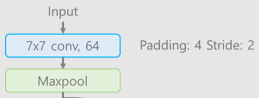

In [ ]:
#resnet 시작 부분
def conv_start() :
  return nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=7, stride = 2, padding = 4)
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2)
  )


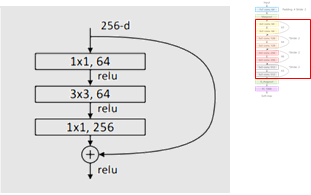

In [ ]:
def bottleneck_block(in_dim, mid_dim, out_dim, down=False):
    layers = []
    if down:
        layers.append(nn.Conv2d(in_dim, mid_dim, kernel_size=1, stride=2, padding=0))
    else:
        layers.append(nn.Conv2d(in_dim, mid_dim, kernel_size=1, stride=1, padding=0))
    layers.extend([
        nn.BatchNorm2d(mid_dim),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_dim, mid_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(mid_dim),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_dim, out_dim, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(out_dim),
    ])
    return nn.Sequential(*layers)

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim, down:bool = False, starting:bool=False) -> None:
        super(Bottleneck, self).__init__()
        if starting:
            down = False
        self.block = bottleneck_block(in_dim, mid_dim, out_dim, down=down)
        self.relu = nn.ReLU(inplace=True)
        if down:
            conn_layer = nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=2, padding=0), # size 줄어듬
        else:
            conn_layer = nn.Conv2d(in_dim, out_dim, kernel_size=1, stride=1, padding=0), # size 줄어들지 않음

        self.changedim = nn.Sequential(conn_layer, nn.BatchNorm2d(out_dim))

    def forward(self, x):
        identity = self.changedim(x)
        x = self.block(x)
        x += identity
        x = self.relu(x)
        return x


In [ ]:
def make_layer(in_dim, mid_dim, out_dim, repeates, starting = False) :
  layers = []
  layers.append(Bottleneck(in_dim, out_dim, down=True, starting = starting))
  for _ in range(1, repeats) :
    layers.append(Bottleneck(out_dim, mid_dim, out_dim, down=False))
    return nn.Sequential(*layers)

    

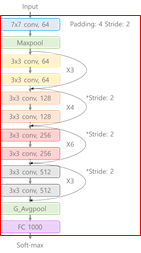

In [ ]:
class ResNet(nn.Module):
    def __init__(self, repeats:list = [3,4,6,3], num_classes=1000):
        super(ResNet, self).__init__()
        self.num_classes = num_classes
        # 1번
        self.conv1 = conv_start()
        
        # 2번
        base_dim = 64
        self.conv2 = make_layer(base_dim, base_dim, base_dim*4, repeats[0], starting=True)
        self.conv3 = make_layer(base_dim*4, base_dim*2, base_dim*8, repeats[1])
        self.conv4 = make_layer(base_dim*8, base_dim*4, base_dim*16, repeats[2])
        self.conv5 = make_layer(base_dim*16, base_dim*8, base_dim*32, repeats[3])
        
        # 3번
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.classifer = nn.Linear(2048, self.num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        # 3번 2048x1 -> 1x2048
        x = x.view(x.size(0), -1)
        x = self.classifer(x)
        return x